In [1]:
import numpy as np
import scipy.integrate as si
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# vectorized input
# "x" = y[:,0]
# "xdot" = y[:,1]

# vectorized output
# "xdot" = f[:,0]
# "xddot" = f[:,1]

def rabi(t, y, params):
    v, omega0, omega = params
    rhsmat = -1j*np.array([[0,v*np.exp(-1j*omega0*t)*np.cos(omega*t)],[v*np.exp(1j*omega0*t)*np.cos(omega*t),0]])
    f = rhsmat @ y
    return f

def rabirotatingwave(t, y, params):
    v, alpha = params
    # rotating wave
    rhsmat = -0.5j*np.array([[0,v*np.exp(1j*alpha*t)],[v*np.exp(-1j*alpha*t),0]], dtype=np.complex128)
    f = rhsmat @ y
    return f

In [3]:
mypar = np.array([0.01,1.0,1.5])
print(mypar)
tf = 50
npts = 500
t_span = np.array([0, tf])
t_eval = np.linspace(0, tf, npts)
y0 = np.array([1.0, 0.0], dtype=np.complex128)
ysolstruct = si.solve_ivp(rabi, t_span=t_span, y0=y0, method='RK45', t_eval=t_eval, 
                          dense_output=False, events=None, vectorized=True, args=(mypar,),
                          rtol=1e-9, atol=1e-9)
ysol = ysolstruct['y']

# cheap diagnostic to check to see if we computed a whole trajectory
print(ysol.shape)

[0.01 1.   1.5 ]
(2, 500)


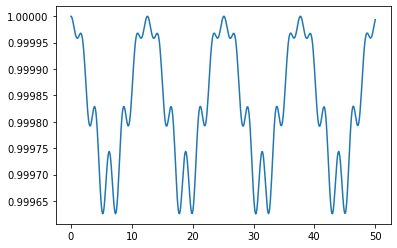

[1. 1. 1.]


In [4]:
plt.plot(t_eval, np.abs(ysol[0,:])**2)
plt.show()

testnorm = np.abs(ysol[0,:])**2 + np.abs(ysol[1,:])**2
print(np.array([np.min(testnorm), np.mean(testnorm), np.max(testnorm)]))

In [5]:
def rabiexact(t, y0, params):
    v, omega0, omega = params
    alpha = omega - omega0
    omegaR = 0.5*np.sqrt(alpha**2 + v**2)
    sol11 = np.exp(0.5j*t*alpha)*(2*omegaR*np.cos(t*omegaR) - 1j*alpha*np.sin(t*omegaR))
    sol12 = -1j*np.exp(0.5j*t*alpha)*v*np.sin(t*omegaR)
    sol21 = -1j*np.exp(-0.5j*t*alpha)*v*np.sin(t*omegaR)
    sol22 = np.exp(-0.5j*t*alpha)*(2*omegaR*np.cos(t*omegaR) + 1j*alpha*np.sin(t*omegaR))
    solmat = np.array([[sol11, sol12], [sol21, sol22]])/(2*omegaR)
    print(solmat.shape)
    return np.einsum('ijk,j->ik',solmat,y0)

In [6]:
def pertc2sq(t, params):
    v, omega0, omega = params
    term1 = np.exp(1j*(omega0+omega)*t) - 1
    term1 /= (omega0 + omega)
    term2 = np.exp(1j*(omega0-omega)*t) - 1
    term2 /= (omega0 - omega)
    cb = -(v/2.0)*(term1 + term2)
    return np.abs(cb)**2

(2, 2, 500)


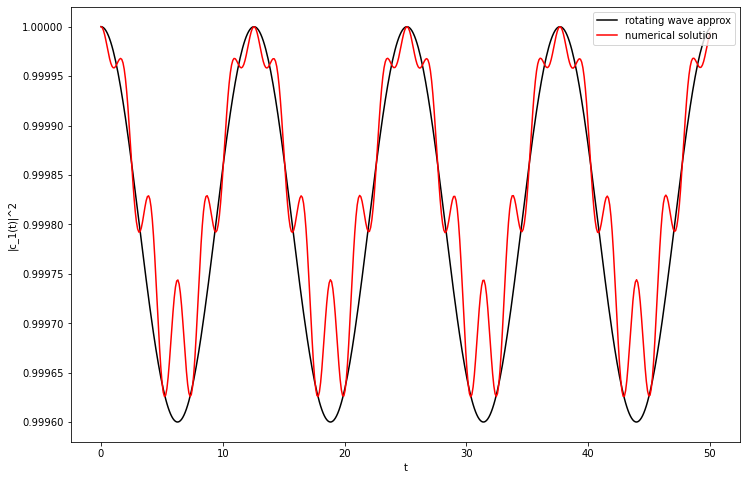

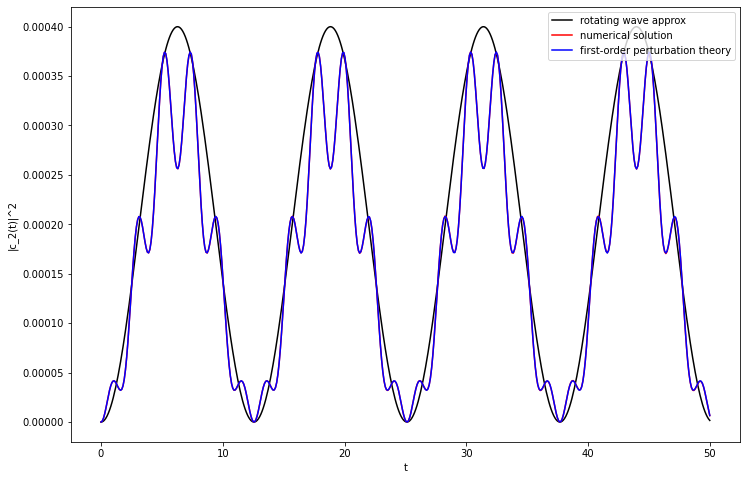

0.0020133639090193483

In [7]:
truesol = rabiexact(t_eval, y0, mypar)
plt.figure(figsize=(12,8))
plt.plot(t_eval, np.abs(truesol[0,:])**2, color='black', label='rotating wave approx')
plt.plot(t_eval, np.abs(ysol[0,:])**2, color='red', label='numerical solution')
plt.legend(loc='upper right')
plt.xlabel('t')
plt.ylabel('|c_1(t)|^2')
plt.savefig('c1squared.png')
plt.show()
plt.figure(figsize=(12,8))
plt.plot(t_eval, np.abs(truesol[1,:])**2, color='black', label='rotating wave approx')
plt.plot(t_eval, np.abs(ysol[1,:])**2, color='red', label='numerical solution')
plt.plot(t_eval, pertc2sq(t_eval, mypar), color='blue', label='first-order perturbation theory')
plt.legend(loc='upper right')
plt.xlabel('t')
plt.ylabel('|c_2(t)|^2')
plt.savefig('c2squared.png')
plt.show()

np.sqrt(np.mean(np.abs(truesol - ysol)**2))